In [84]:
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

In [85]:
colnames = ['class', 'a1', 'a2', 'a3','a4','a5','a6','id']
dataset1 = pd.read_csv("../input_data/RobotDataset/Robot1", names=colnames, header=None,delim_whitespace=True)
dataset2 = pd.read_csv("../input_data/RobotDataset/Robot2", names=colnames, header=None,delim_whitespace=True)
frames = [dataset1,dataset2]
dataset = pd.concat(frames)
colnames = ['sepall', 'sepalw', 'petall', 'petalw','class']
dataset2 = pd.read_csv("../input_data/Iris/Iris.csv", names=colnames, header=None)

In [86]:
dataset.head()

class  a1  a2  a3  a4  a5  a6       id
0      1   1   1   1   1   3   1   data_5
1      1   1   1   1   1   3   2   data_6
2      1   1   1   1   3   2   1  data_19
3      1   1   1   1   3   3   2  data_22
4      1   1   1   2   1   2   1  data_27

In [87]:
dataset2.head()

sepall  sepalw  petall  petalw           class
0     5.1     3.5     1.4     0.2     Iris-setosa
1     6.3     3.3     6.0     2.5  Iris-virginica
2     5.0     3.0     1.6     0.2     Iris-setosa
3     6.2     2.8     4.8     1.8  Iris-virginica
4     6.4     3.1     5.5     1.8  Iris-virginica

In [88]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

In [89]:
def euclidean(v1,v2):
    ary = spatial.distance.cdist(v1,v2, metric='euclidean')
    return ary[0,0]

In [90]:
def minkowski(v1,v2):
    ary = spatial.distance.cdist(v1,v2, metric='minkowski')
    return ary[0,0]

In [91]:
def cosine(v1,v2):
    ary = spatial.distance.cdist(v1,v2, metric='cosine')
    return ary[0,0]

In [92]:
def distances(dataset,sample,metric):
    dist = []
    l = len(dataset)
    for i in range(l):
        dist.append(metric(dataset.iloc[[i]],sample))
    return np.asarray(dist)

In [93]:
def knn(dataset,sample,y,classes,k,metric):
    dist = distances(dataset,sample,metric)
    indices = dist.argsort()[:3]
    counts = np.zeros(len(classes))
    for i in indices:
        counts[classes.index(y.iloc[i])] += 1
    return classes[np.argmax(counts)]

In [94]:
def train_validate_test_split(dataset):
    size = len(dataset)
    tsize = int(size*0.6)
    vsize = int(size*0.8)
    training_data = dataset.iloc[:tsize].reset_index(drop=True)
    validation_data = dataset.iloc[tsize:vsize].reset_index(drop=True)
    testing_data = dataset.iloc[vsize:].reset_index(drop=True)
    return training_data,validation_data,testing_data

In [112]:
def knn_algorithm_iris(training_data,test_data,classes,k,metric):
    ttrain = training_data[['sepall', 'sepalw', 'petall', 'petalw']]
    ttest = test_data[['sepall', 'sepalw', 'petall', 'petalw']]
    y = training_data['class']
    pred = []
    for i in range(len(ttest)):
        pred.append(knn(ttrain,ttest.iloc[[i]],y,classes,k,metric))
    return pred

In [120]:
def knn_algorithm_robot(training_data,test_data,classes,k,metric):
    ttrain = training_data[['a1', 'a2', 'a3','a4','a5','a6']]
    ttest = test_data[['a1', 'a2', 'a3','a4','a5','a6']]
    y = training_data['class']
    pred = []
    for i in range(len(ttest)):
        pred.append(knn(ttrain,ttest.iloc[[i]],y,classes,k,metric))
    return pred

In [121]:
def confusionmatrix(preds,y,classes):
    n = len(preds)
    noc = len(classes)
    matrix = np.zeros((noc,noc))
    for i in range(n):
        r = classes.index(preds[i])
        c = classes.index(y[i])
        matrix[r][c] += 1
    return matrix

In [122]:
def stats2(confusionmatrix,classes): 
    n = len(classes)
    precision = np.zeros(n)
    recall = np.zeros(n)
    f1 = np.zeros(n)
    colsums = confusionmatrix.sum(axis=0)
    rowsums = confusionmatrix.sum(axis=1)
    dval = 0
    for i in range(n):
        precision[i] = confusionmatrix[i,i]/colsums[i]
        recall[i] = confusionmatrix[i,i]/rowsums[i]
        f1[i] = safe_div(2,(safe_div(1,precision[i]))+safe_div(1,recall[i]))
        dval += confusionmatrix[i,i]
    return dval/np.sum(confusionmatrix)

In [123]:
def stats(confusionmatrix,classes): 
    n = len(classes)
    precision = np.zeros(n)
    recall = np.zeros(n)
    f1 = np.zeros(n)
    colsums = confusionmatrix.sum(axis=0)
    rowsums = confusionmatrix.sum(axis=1)
    dval = 0
    for i in range(n):
        precision[i] = confusionmatrix[i,i]/colsums[i]
        recall[i] = confusionmatrix[i,i]/rowsums[i]
        f1[i] = safe_div(2,(safe_div(1,precision[i]))+safe_div(1,recall[i]))
        dval += confusionmatrix[i,i]
    for i in range(n):
        print("Recall of class",classes[i],":",recall[i])
        print("Precision of class",classes[i],":",precision[i])
        print("F1 Score of class",classes[i],":",f1[i])
        print('\n')
    print("Accuracy:",dval/np.sum(confusionmatrix))
    print("Classification error:",1-(dval/np.sum(confusionmatrix)))
    print("Overall Precision:",np.mean(precision))
    print("Overall Recall:",np.average(recall))
    print("Overall F1 Score:",np.mean(f1))

In [124]:
def sklearnstats(data):
    datanames = ['training data','validation data','testing data']
    from sklearn.metrics import confusion_matrix
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=3)
    X = data[0].drop('class',axis=1)
    y = data[0]['class']
    neigh.fit(X, y)
    for i in range(len(data)):
        print("Accuracy on:",datanames[i])
        preds = neigh.predict(data[i].drop('class',axis=1))
        con_mat = confusion_matrix(data[i]['class'], preds)
        stats(con_mat,data[i]['class'].unique())
        print("\n\n\n")

In [125]:
print("Robot Dataset Graphs")

Robot Dataset Graphs


In [126]:
training_data,validation_data,testing_data = train_validate_test_split(dataset)
classes = list(training_data['class'].unique())
print(classes)
preds = knn_algorithm_robot(training_data,training_data,classes,3,euclidean)

[1, 0]


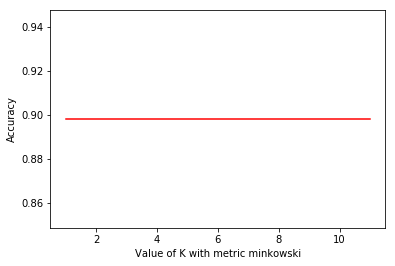

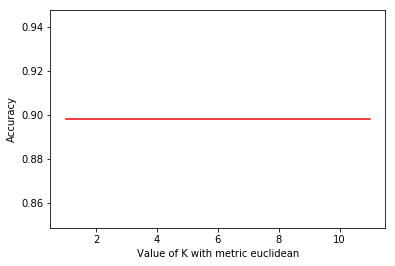

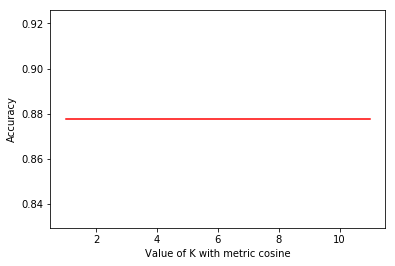

In [128]:
metrics = [minkowski,euclidean,cosine]
metricsname = ['minkowski','euclidean','cosine']
for i in range(len(metrics)):
    px = []
    py = []
    for k in range(1,12,2):
        preds = knn_algorithm_robot(training_data,training_data,classes,k,metrics[i])
        cm = confusionmatrix(preds,list(training_data['class']),list(training_data['class'].unique()))
        px.append(k)
        py.append(stats2(cm,training_data['class'].unique()))
    plt.plot(px,py, color='r')
    plt.xlabel('Value of K with metric '+metricsname[i])
    plt.ylabel('Accuracy')
    plt.show()

In [30]:
print("Iris Dataset Graphs")

Iris Dataset Graphs


In [131]:
training_data,validation_data,testing_data = train_validate_test_split(dataset2)
classes = list(training_data['class'].unique())
preds = knn_algorithm_iris(training_data,training_data,classes,3,euclidean)

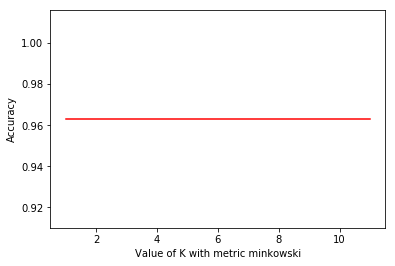

In [132]:
metrics = [minkowski,euclidean,cosine]
metricsname = ['minkowski','euclidean','cosine']
for i in range(len(metrics)):
    px = []
    py = []
    for k in range(1,12,2):
        preds = knn_algorithm_iris(training_data,training_data,classes,k,metrics[i])
        cm = confusionmatrix(preds,list(training_data['class']),list(training_data['class'].unique()))
        px.append(k)
        py.append(stats2(cm,training_data['class'].unique()))
    plt.plot(px,py, color='r')
    plt.xlabel('Value of K with metric '+metricsname[i])
    plt.ylabel('Accuracy')
    plt.show()

In [133]:
# Observations:
# From the plot we can see that the value of k is not making any effect on the model performance
# because of less data. if more data is available the algorithm may perform better. And it may also mean 
# that the datapoints in the dataset are so close such that the K in KNN is not making any difference